In [328]:
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import ast
from textblob import TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
import re
from nltk.corpus import wordnet, stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag

In [329]:
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('vader_lexicon')

[nltk_data] Downloading package omw-1.4 to /Users/huyguy/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/huyguy/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/huyguy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/huyguy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/huyguy/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/huyguy/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [330]:
airline = pd.read_csv('Data/airline-reviews.csv')
seat = pd.read_csv('Data/seat-reviews.csv')
lounge = pd.read_csv('Data/lounge-reviews.csv')

In [331]:
airline['Review Body'].head(20)

0     ✅ Trip Verified |   On a recent flight from Cy...
1     ✅ Trip Verified |   Flight BA 0560 arrived in ...
2     ✅ Trip Verified |   This was the first time I ...
3     ✅ Trip Verified |   Pretty good flight but sti...
4     ✅ Trip Verified | Check in was fine, but no pr...
5     ✅ Trip Verified | British Airways is absolute ...
6     ✅ Trip Verified | The flight time was changed ...
7     ✅ Trip Verified |   I'm so fraustrated. My fli...
8     ✅ Trip Verified | We have sat on this plane fo...
9     Not Verified |  British Airways stranding my w...
10    ✅ Trip Verified |   Although like many these d...
11    ✅ Trip Verified | This flight was British Airw...
12    Not Verified | The worst airline I have ever f...
13    ✅ Trip Verified |   Disappointing service, pla...
14    ✅ Trip Verified |   A transit visa is required...
15    ✅ Trip Verified |   I was surprised to receive...
16    ✅ Trip Verified |   Flight cancelled, not refu...
17    ✅ Trip Verified |   I had visa issues, and

## Data cleaning

#### Cleaning the text

In [332]:
def remove_trip_verification(review):
    '''Remove unwanted phrases'''
    if '✅ Trip Verified |' in review:
        review = review.replace('✅ Trip Verified |', '')
    if 'Not Verified |' in review:
        review = review.replace('Not Verified |', '')
    return review

In [333]:
# Remove unwanted phrases from reviews
airline['Review Body'] = airline['Review Body'].apply(remove_trip_verification)
seat['Review Body'] = seat['Review Body'].apply(remove_trip_verification)
lounge['Review Body'] = lounge['Review Body'].apply(remove_trip_verification)

In [334]:
def clean(text):
    '''Remove non alphabetical characters'''
    # Replace non-alphabetic characters with a single space
    text = re.sub('[^A-Za-z]+', ' ', text)   
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)
    # Remove leading/trailing spaces
    text = text.strip()
    return text

In [335]:
airline['Review Body'] = airline['Review Body'].apply(clean)
seat['Review Body'] = seat['Review Body'].apply(clean)
lounge['Review Body'] = lounge['Review Body'].apply(clean)

#### Tokenization --> POS tagging --> Stopwords removal

In [336]:
pos_dict = {'J': wordnet.ADJ, 'V': wordnet.VERB, 'N': wordnet.NOUN, 'R': wordnet.ADV} # Abbreviations
stop_words = set(stopwords.words('english')) # Chat GPT suggests convert to set for faster lookup

In [337]:
def token_stop_pos(text):
    '''Break reviews down to separate words and match them with tags indicating their grammar form '''
    # Tokenize and POS tagging
    tags = pos_tag(word_tokenize(text))
    result = []

    # Loop through each word and its POS tag in the tagged list
    for word, tag in tags:
        # Check if the word is not a stopword
        if word.lower() not in stop_words:
            # Get the POS tag from the dictionary using the first letter of the tag
            pos = pos_dict.get(tag[0])
            # Create a tuple of the word and its POS tag, then add it to the result list
            result.append((word, pos))
    
    # Return the list of tuples
    return result

In [338]:
airline['POS tagged'] = airline['Review Body'].apply(token_stop_pos)
seat['POS tagged'] = seat['Review Body'].apply(token_stop_pos)
lounge['POS tagged'] = lounge['Review Body'].apply(token_stop_pos)

#### Lemmization

In [339]:
wordnet_lemmatizer = WordNetLemmatizer()
def lemmatize(pos_data):
    """
    Lemmatizes a list of (word, pos) tuples.
    If a word has no POS tag, it is left unchanged.
    Args: pos_data (list): List of tuples where each tuple contains a word and its POS tag.
    Returns: str: A single string of lemmatized words.
    """
    lemma_sentence = ""  # Initialize an empty string to store the lemmatized sentence
    # Loop through each (word, pos) pair in the input
    for word, pos in pos_data:
        if not pos:  # If the word has no POS tag
            lemma = word  # Keep the word as it is
        else:  # If the word has a POS tag
            lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)  # Lemmatize based on the tag  
        # Add the lemmatized word (or original word) to the sentence
        lemma_sentence += " " + lemma
    return lemma_sentence  # Return the full lemmatized sentence

In [340]:
airline['Review Body'] = airline['POS tagged'].apply(lemmatize)
seat['Review Body'] = seat['POS tagged'].apply(lemmatize)
lounge['Review Body'] = lounge['POS tagged'].apply(lemmatize)

In [341]:
def expand_review_stats(df):
    '''Extract the information from Review Stats'''
    parsed_data = [ast.literal_eval(entry) for entry in df['Review Stats']]
    new_df = pd.json_normalize(parsed_data)
    return pd.concat([df, new_df], axis=1)

In [342]:
airline = expand_review_stats(airline)
seat = expand_review_stats(seat)
lounge = expand_review_stats(lounge)

## Analysis and Visualization

In [362]:
# British Airways color pallette
colors = {
    'Endeavour': '#075aaa',  # Hex for Endeavour
    'Alizarin Crimson': '#eb2226',  # Hex for Alizarin Crimson
    'Midnight Blue': '#01295c',  # Hex for Midnight Blue
    'Pampas': '#efe9e5',  # Hex for Pampas
    'Bronco': '#aca095',  # Hex for Bronco
    'Spindle': '#b9cfed',  # Hex for Spindle
    'Aluminium': '#a7a9ac'  # Hex for Aluminium
}

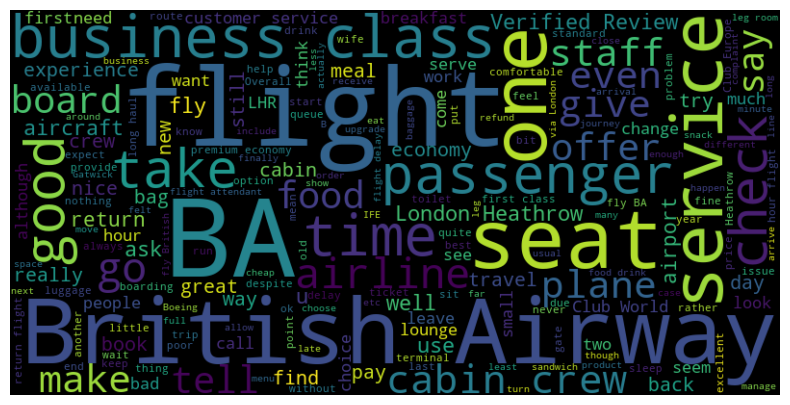

<Figure size 640x480 with 0 Axes>

In [360]:
# Word clouds
all_text = ' '.join(airline['Review Body']) # Combine all reviews into 1 string

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400).generate(all_text)
# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show();

# Save the word cloud image
plt.savefig("wordcloud.jpg", format='jpg')

Popular words that are relevant are seat, business class, cabin crew, food, and service. Our descriptive analysis will focus on these key areas, mainly seat experience, ticket class, food, and customer services. 

In [344]:
# VADER Sentiment Intensity Analyzer
sia = SentimentIntensityAnalyzer()
# Calculate sentiment polarity and return the compound score
def get_sentiment_and_score(review):
    sentiment_scores = sia.polarity_scores(review)  # Get the sentiment scores for the review
    compound = sentiment_scores['compound'] # Determine sentiment based on the compound score
    if compound > 0.5:
        sentiment = 'Positive'
    elif compound < 0:
        sentiment = 'Negative'
    else:
        sentiment = 'Neutral'
    return sentiment, compound

In [345]:
# Apply the function to the 'review' column and create two new columns: 'sentiment' and 'compound_score'
airline[['Sentiment', 'Compound_score']] = airline['Review Body'].apply(lambda review: pd.Series(get_sentiment_and_score(review)))
# View sentiment distribution
airline['Sentiment'].value_counts()

Sentiment
Positive    2233
Negative    1259
Neutral      411
Name: count, dtype: int64

The majority of reviewers had a positive experience flying with British Airways.  

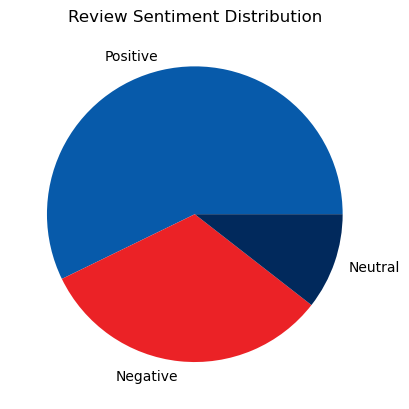

<Figure size 640x480 with 0 Axes>

In [399]:
# pie chart for the sentiment distribution
colors = ['#075aaa', '#eb2226', '#01295c']
# Create figure and axis
fig, ax = plt.subplots()
# Pie chart for sentiment distribution with specified colors
airline.Sentiment.value_counts(normalize=True).plot.pie(ax=ax, colors=colors)
ax.set_title('Review Sentiment Distribution')
ax.axis('off')
plt.show()
plt.tight_layout()

# Save the image after the plot is shown
fig.savefig("sentiment_distribution.jpg", format='jpg')

In [347]:
airline['Date Published'] = pd.to_datetime(airline['Date Published'], errors='coerce')
airline['YearMonth'] = airline['Date Published'].dt.to_period('M')
sentiment_trends = airline.groupby(['YearMonth'])['Sentiment'].value_counts().unstack()
sentiment_trends

Sentiment,Negative,Neutral,Positive
YearMonth,,,
2011-10,1.0,NaN,2.0
2012-08,2.0,1.0,9.0
2014-04,NaN,NaN,1.0
2014-05,11.0,5.0,33.0
2014-06,15.0,5.0,54.0
...,...,...,...
2024-08,11.0,5.0,9.0
2024-09,7.0,NaN,5.0
2024-10,7.0,1.0,6.0


## Descriptive Analysis

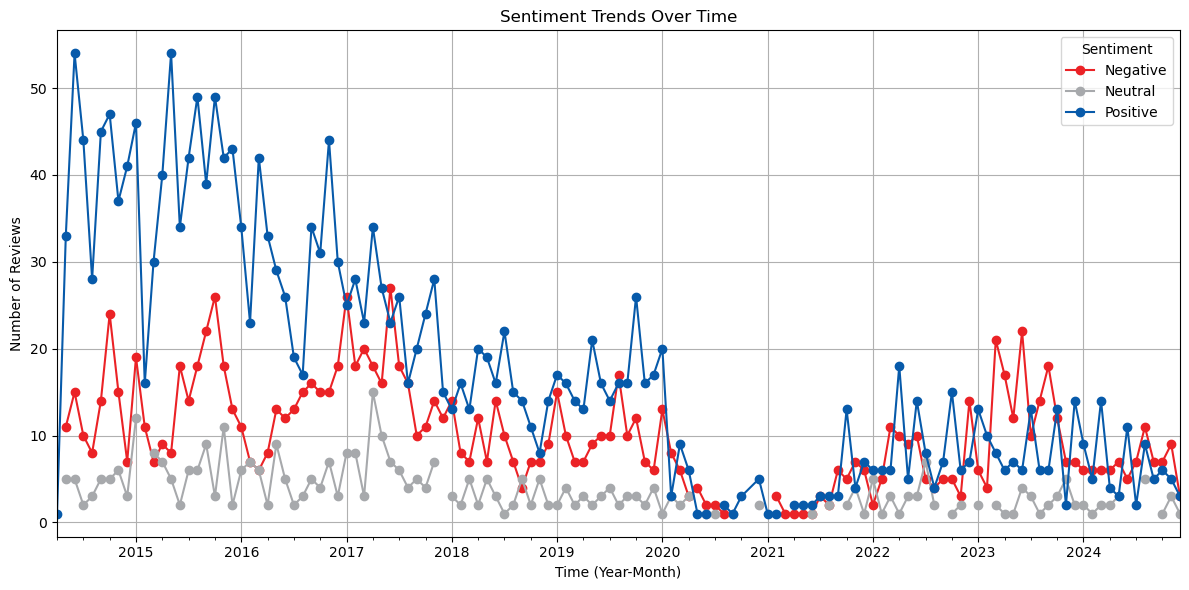

In [390]:
colors = ['#eb2226', '#a7a9ac', '#075aaa']
# Sentiment overtime
sentiment_trends_filtered = sentiment_trends[sentiment_trends.index >= '2014-01']
sentiment_trends_filtered.plot(kind='line', figsize=(12, 6), marker='o', color = colors)
plt.title('Sentiment Trends Over Time')
plt.xlabel('Time (Year-Month)')
plt.ylabel('Number of Reviews')
plt.legend(title='Sentiment')
plt.grid(True)
plt.tight_layout()

# Save the image
plt.savefig("sentiment overtime.jpg", format='jpg')

plt.show()

The trends indicate a review decline, which may be attributed to a shift in review preferences towards newer platforms. However, post-COVID trends suggest a decrease in positive experiences compared to negative experiences, signaling a regression in service quality.

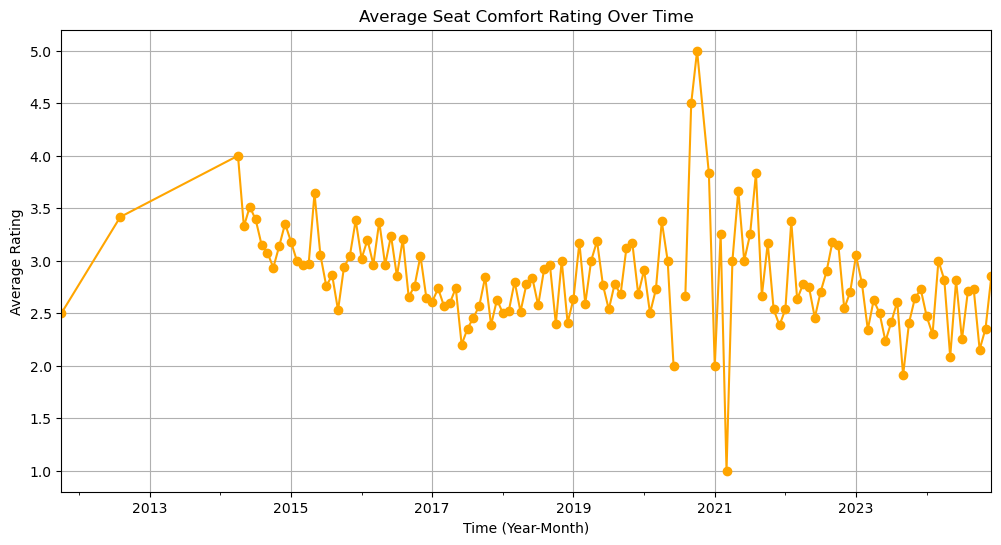

In [349]:
seat_comfort = airline.groupby('YearMonth')['Seat Comfort'].mean()
# Plot average ratings
seat_comfort.plot(kind='line', figsize=(12, 6), marker='o', color='orange')
plt.title('Average Seat Comfort Rating Over Time')
plt.xlabel('Time (Year-Month)')
plt.ylabel('Average Rating')
plt.grid(True)
plt.show()

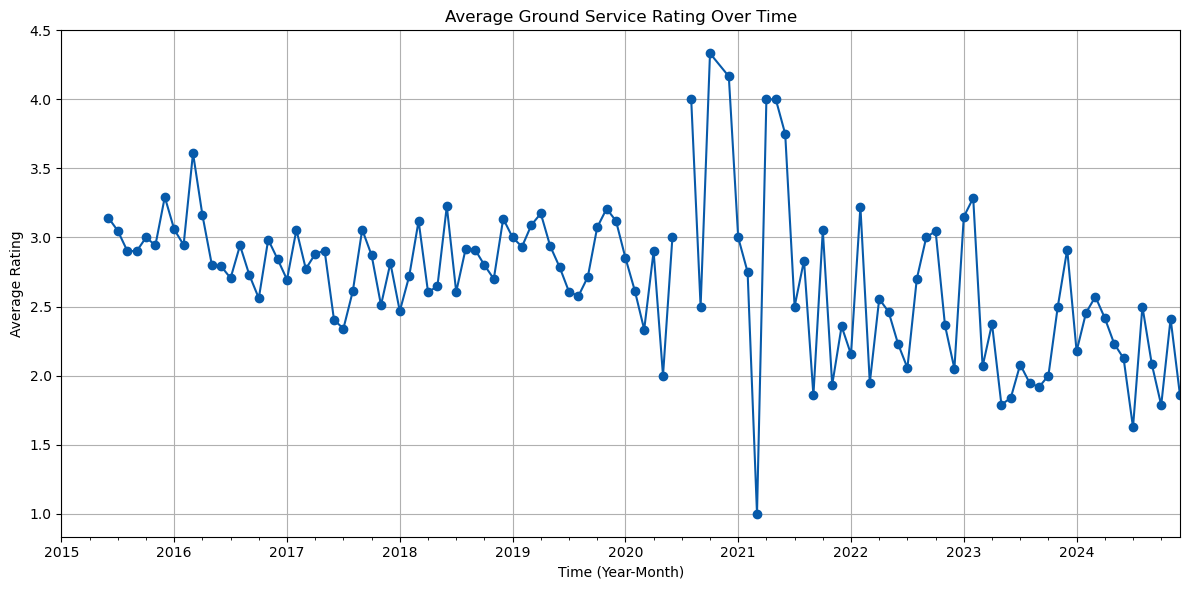

In [389]:
ground_service = airline.groupby('YearMonth')['Ground Service'].mean()
# Plot average ratings
ground_service_filtered = ground_service[ground_service.index >= '2015-01']
ground_service_filtered.plot(kind='line', figsize=(12, 6), marker='o', color='#075aaa')
plt.title('Average Ground Service Rating Over Time')
plt.xlabel('Time (Year-Month)')
plt.ylabel('Average Rating')
plt.grid(True)
plt.tight_layout()

# Save the image
plt.savefig("ground service rating.jpg", format='jpg')

plt.show()

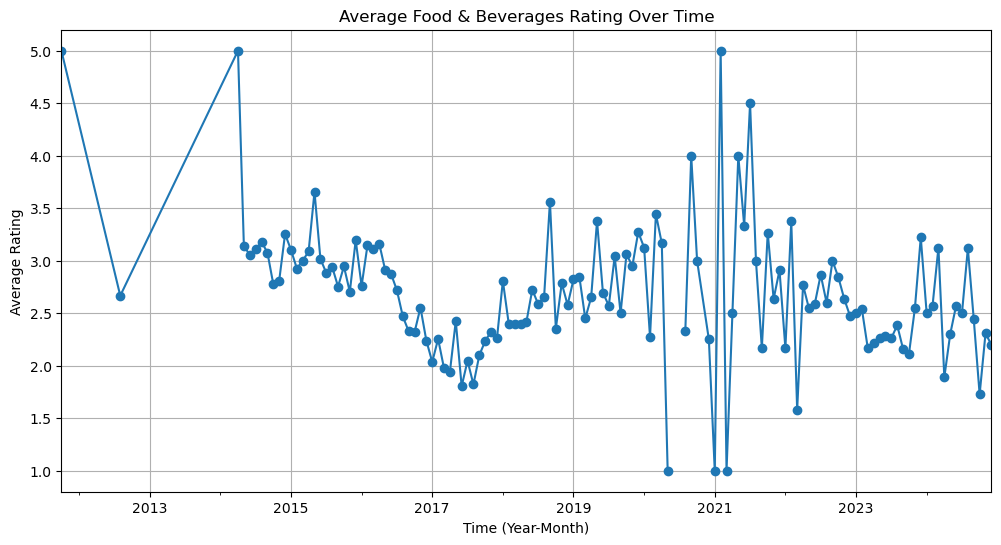

In [377]:
food_beverages = airline.groupby('YearMonth')['Food & Beverages'].mean()
# Plot average ratings
food_beverages.plot(kind='line', figsize=(12, 6), marker='o')
plt.title('Average Food & Beverages Rating Over Time')
plt.xlabel('Time (Year-Month)')
plt.ylabel('Average Rating')
plt.grid(True)
plt.show()

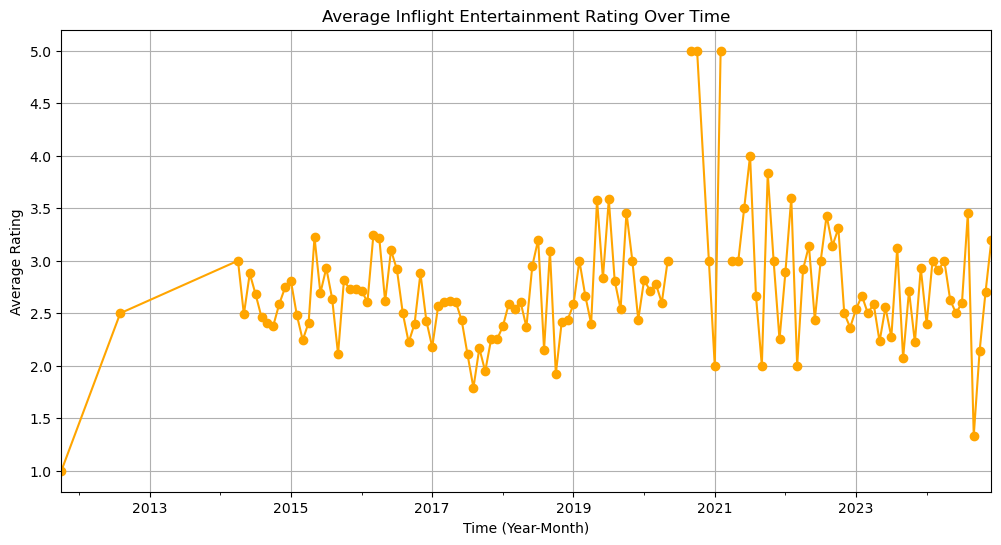

In [320]:
inflight_entertainment = airline.groupby('YearMonth')['Inflight Entertainment'].mean()
# Plot average ratings
inflight_entertainment.plot(kind='line', figsize=(12, 6), marker='o', color='orange')
plt.title('Average Inflight Entertainment Rating Over Time')
plt.xlabel('Time (Year-Month)')
plt.ylabel('Average Rating')
plt.grid(True)
plt.show()

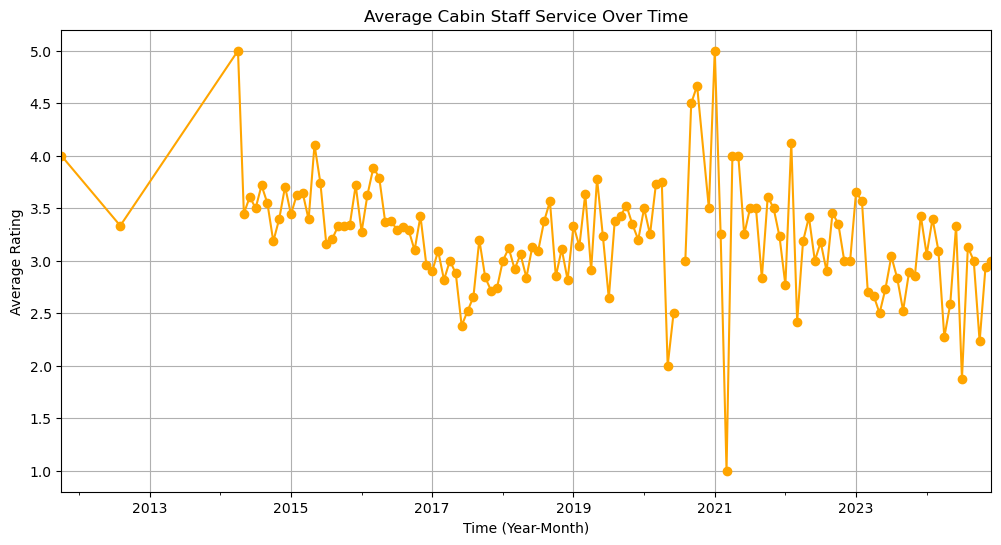

In [321]:
seat_comfort = airline.groupby('YearMonth')['Cabin Staff Service'].mean()
# Plot average ratings
seat_comfort.plot(kind='line', figsize=(12, 6), marker='o', color='orange')
plt.title('Average Cabin Staff Service Over Time')
plt.xlabel('Time (Year-Month)')
plt.ylabel('Average Rating')
plt.grid(True)
plt.show()

Across most key metrics, the trends have remained stable, hovering around ratings of 3 to 3.5. This suggests that there hasn't been a significant change over time. Achieving notable progress in these areas could signal to customers that the brand is evolving positively, reinforcing trust with existing customers and attracting new ones. Additionally, the decline in Ground Service ratings highlights the need for more focused attention in this area to prevent further deterioration and improve overall customer satisfaction.

In [406]:
# Group the reviews by seat type and calculate the mean rating for each service
seat_type_reviews = airline.groupby('Seat Type')[['Seat Comfort', 'Cabin Staff Service', 'Food & Beverages', 
                                                  'Inflight Entertainment', 'Ground Service', 'Value For Money', 'Wifi & Connectivity']].mean()
seat_type_reviews.T

Seat Type,Business Class,Economy Class,First Class,Premium Economy
Seat Comfort,2.903614,2.707605,3.674312,3.032787
Cabin Staff Service,3.441224,3.048579,3.926606,3.134247
Food & Beverages,2.949461,2.472255,3.222222,2.690544
Inflight Entertainment,2.695163,2.487903,3.084158,2.791045
Ground Service,2.910808,2.603636,3.166667,2.885017
Value For Money,2.752950,2.564619,3.063927,2.654255
Wifi & Connectivity,2.102222,1.765896,2.023810,2.194444


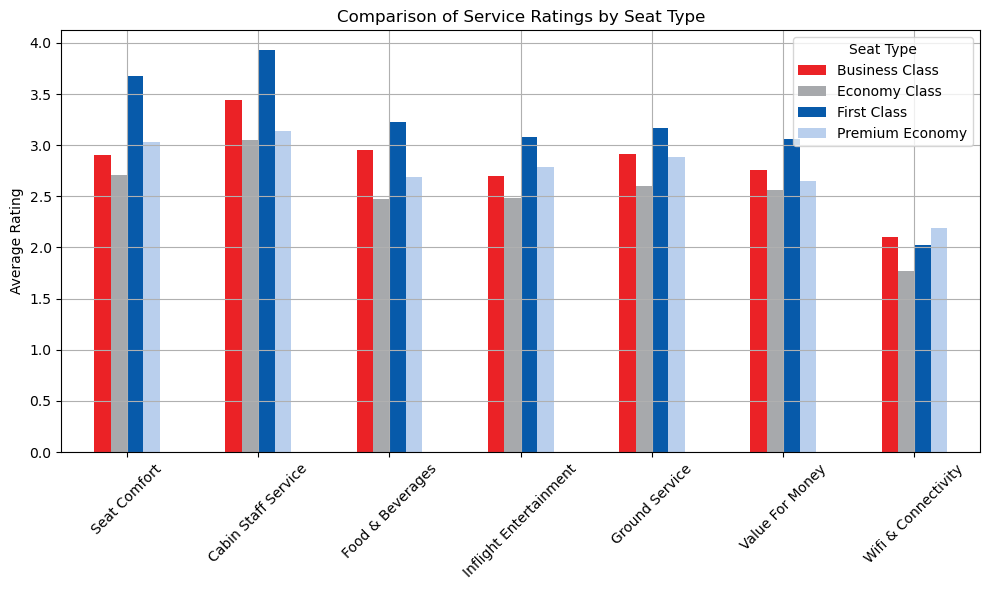

In [407]:
colors = ['#eb2226', '#a7a9ac', '#075aaa', '#b9cfed']
# Plot average ratings for each service across different seat types
seat_type_reviews.T.plot(kind='bar', figsize=(10, 6), color = colors)
plt.title('Comparison of Service Ratings by Seat Type')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Save the image
plt.savefig("average ratings.jpg", format='jpg')

plt.show();

Comparing the numbers above, here are the following observations:
1. Economy Flyers: The Lowest Scores Across All Metrics

Observation: Economy class consistently rates the lowest in all categories, yet represents the majority of flyers.
  
Actionable Insights:
- Focus on high-impact, low-cost improvements: Identify pain points such as seating comfort or ground service and implement changes that don't drastically increase costs.
- Customer feedback surveys: Gather direct input from economy-class flyers to pinpoint specific dissatisfaction areas.
Marketing opportunities: Highlight incremental service enhancements to create a perception of improved value, even if major cost reductions aren't feasible.

2. Value for Money: Similar Scores Across Classes

Observation: Across all seat types, "Value for Money" received the most consistent and middling scores.

Actionable Insights:
- Price optimization: Analyze pricing structures to ensure they're competitive relative to service quality and industry benchmarks.
- Enhance perception of value: Offer small, tangible perks like free Wi-Fi or complimentary snacks across classes to elevate perceived value.
- Package deals: Create bundled offers (e.g., airfare + lounge access) that improve the value perception without significant additional costs.


3. Premium vs. Business Class: Similar Except in Food & Beverages

Observation: The only standout difference between premium and business class ratings is in "Food & Beverages."

Actionable Insights:
- Resource sharing: Align procurement and preparation processes for premium and business classes to reduce costs while maintaining quality.
- Differentiate the experience: Enhance food and beverage offerings in business class to create a stronger distinction or find creative ways to bridge the gap.
- Cross-utilization of resources: Implement shared staff or overlapping services between these classes to maximize efficiency.

In [400]:
airline.columns

Index(['Title', 'Author', 'Date Published', 'Review Body', 'Review Stats',
       'POS tagged', 'Type Of Traveller', 'Seat Type', 'Route', 'Date Flown',
       'Seat Comfort', 'Cabin Staff Service', 'Food & Beverages',
       'Inflight Entertainment', 'Ground Service', 'Value For Money',
       'Recommended', 'Aircraft', 'Wifi & Connectivity', 'Sentiment',
       'Compound_score', 'YearMonth'],
      dtype='object')

Wifi & Connectivity
1.0    412
3.0     87
2.0     74
4.0     57
5.0     56
Name: count, dtype: int64